# Курсовой проект

**Содержание**
* [Загрузка библиотек и данных](#load)
* [EDA](#eda)
* [Очистка данных](#clean)
* [Построение модели](#model)
* [Сохранение прогнозов](#forc)

## Загрузка библиотек и данных <a class='anchor' id='load'>

**Библиотеки**

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

**Пути к данным**

In [2]:
TRAIN_DATASET_PATH = 'train.csv' # y_train, y_valid
TEST_DATASET_PATH = 'test.csv'

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [3]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

## EDA <a class='anchor' id='eda'>

**Анализ таргета**

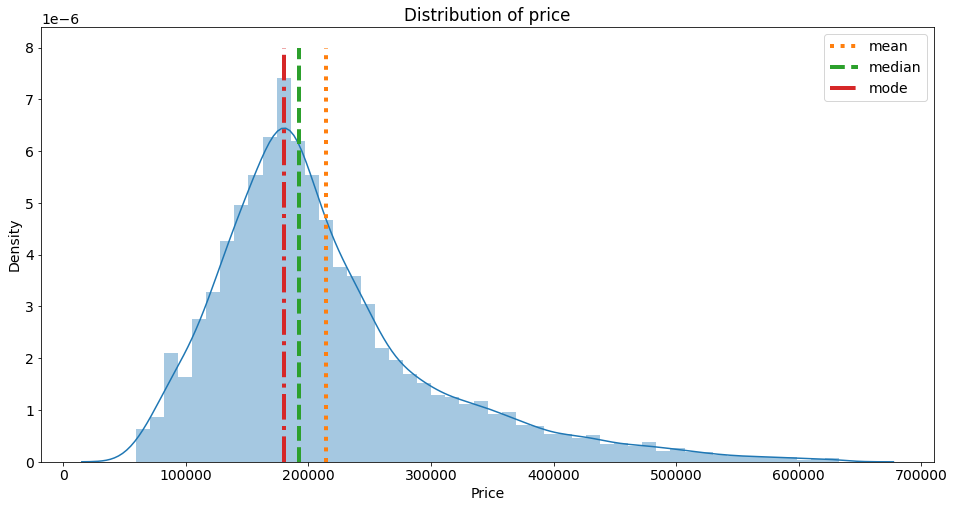

In [4]:
# check mean, median and mode
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()

# devide data to bins to get correct mode
target_bins = train_df['Price'] // 10000 * 10000
target_adjusted_mode = target_bins.mode()[0]

# plot results
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000008, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_adjusted_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of price')
plt.legend()
plt.show()

Данные распределены хорошо, судя по моде сильных выбросов нету. Кажется преобразования не нужны.

**Анализ признаков**\
**Количественные признаки**

In [5]:
train_df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
train_df_num_features.drop('Price', axis=1, inplace=True)

train_df_num_features.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


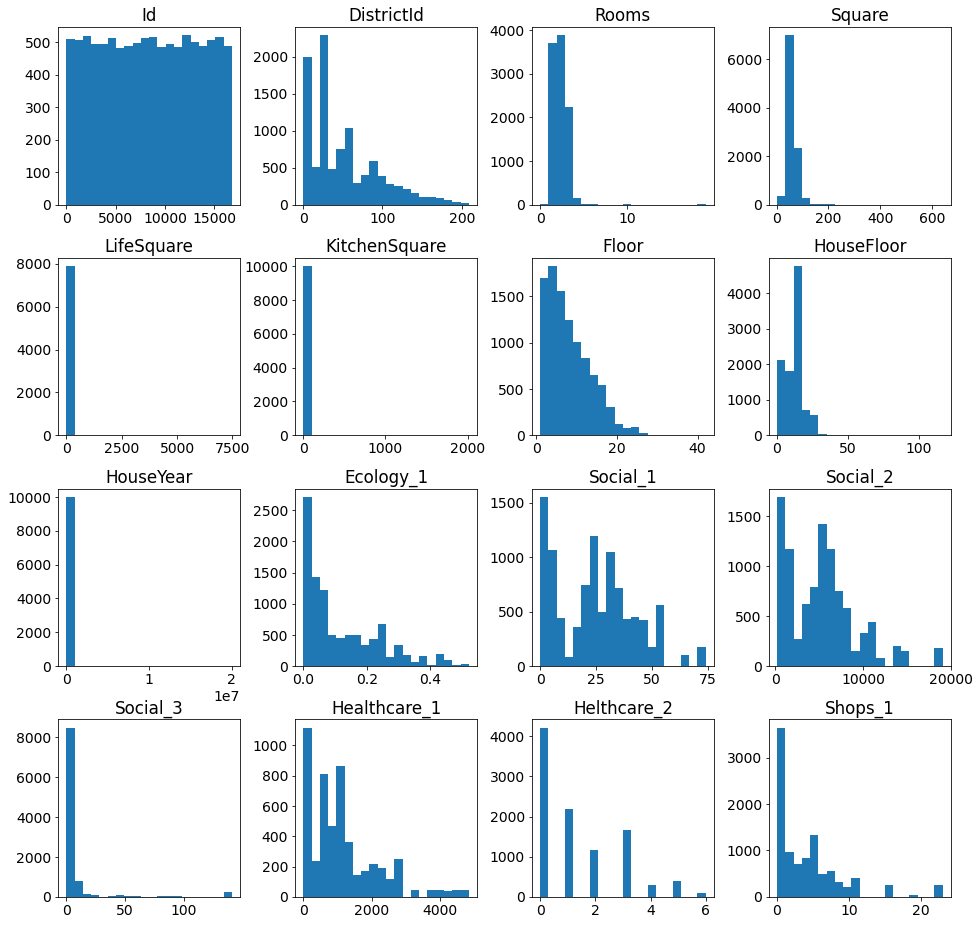

In [6]:
train_df_num_features.hist(figsize=(16,16), bins=20, grid=False);

Наблюдения:
* В переменных LifeSquare, Healthcare_1 не хватает данных;
* Rooms: значение min = 0 странное, также max = 19 при q(0.75) = 2;
* Square: значение min = 1.13 странное, как и max = 641.06 при q(0.75) = 65.90;
* LifeSquare: значение min = 0.37 странное, как и max = 7480.59 при q(0.75) = 45.12;
* KitchenSquare: значение min = 0 странное, как и max = 2014 при q(0.75) = 9;
* Square по максимальным значениям не равна LifeSquare + KitchenSquare. Возможно это наблюдается ещё где-то;
* HouseFloor: значение min = 0 странное, как и max = 117 при q(0.75) = 17;
* HouseYear: strange max value
* Social_3: не понятно что это, но значение max = 141 при q(0.75) = 5 странное;
* Shops_1: похоже на кол-во магазинов в огруге, значение max = 23 при q(0.75) = 6 странное.

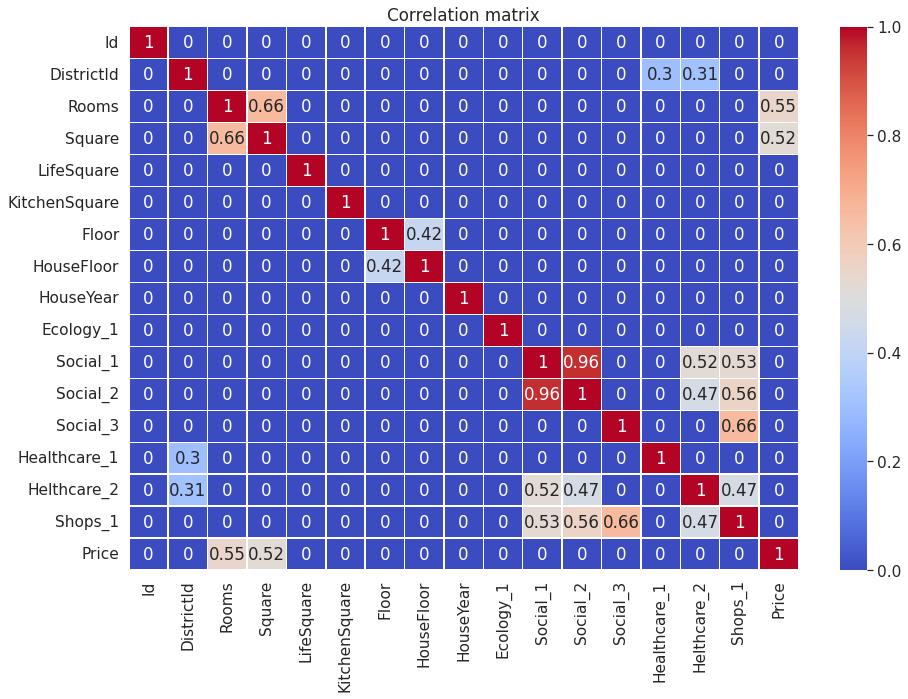

In [7]:
# also check correlations
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Наблюдения:
* Цена несильно коррелирует с кол-вом комнат и общей площадью
* Есть сильная корреляция между Social_1 и Social_2

**Категориальные признаки**

In [8]:
train_df_cat_features = train_df.select_dtypes(include=['object'])
cat_colnames = train_df_cat_features.columns.tolist()
cat_colnames

['Ecology_2', 'Ecology_3', 'Shops_2']

In [9]:
# check all non-id values
for col in cat_colnames:
    print(str(col) + '\n\n' + str(train_df_cat_features[col].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



Наблюдения:
* DistrictId возможно обозначает район города, и от него может зависить цена.
* Остальные категориальные признаки в основном содержат значение В

## Очистка данных <a class='anchor' id='clean'>

In [10]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.r_median = None
        self.hf_median = None
        self.hc_median = None
        self.square_med_diff = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет медиан
        self.r_median, self.hf_median, self.hc_median = df[['Rooms', 'HouseFloor', 'Healthcare_1']].median()
        self.square_med_diff = (df.loc[df['LifeSquare'].notnull(), 'Square'] -
                   df.loc[df['LifeSquare'].notnull(), 'LifeSquare'] -
                   df.loc[df['LifeSquare'].notnull(), 'KitchenSquare']).median()
        
    def transform(self, df):
        """Трансформация данных"""

        # 0. Изменить на категориальные
        
        df['Id'] = df['Id'].astype(str)
        df['DistrictId'] = df['DistrictId'].astype(str)
        
        # 1. Пропуски
        df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] =\
        df.loc[df['LifeSquare'].isnull(), 'Square'] -\
        df.loc[df['LifeSquare'].isnull(), 'KitchenSquare'] - self.square_med_diff
        
        df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = self.hc_median
        
        
        # 2. Выбросы (outliers)
        df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
        df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2005
        df.loc[df['Rooms'] > 9, 'Rooms'] = self.r_median
        df.loc[df['HouseFloor'] > 50, 'HouseFloor'] = self.hf_median
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df.loc[df['HouseFloor'] == 0, 'Floor']
        df = df[df['Square'] < 300]
        df = df[df['LifeSquare'] < 500]
        
        
        # 3. Новые фичи
        district_size = df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        df = df.merge(district_size, on='DistrictId', how='left')
        df['IsDistrictLarge'] = (df['DistrictSize'] > 200).astype(int)
        
        
        # 4. Обработка категорий
        df['Ecology_2_bin'] = df['Ecology_2'].replace({'A':0, 'B':1})
        df['Ecology_3_bin'] = df['Ecology_3'].replace({'A':0, 'B':1})
        df['Shops_2_bin'] = df['Shops_2'].replace({'A':0, 'B':1})

        return df


In [11]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

pipe = DataPipeline()
pipe.fit(train_df)
train_df = pipe.transform(train_df)
test_df = pipe.transform(test_df)

## Построение модели <a class='anchor' id='model'>

In [12]:
def create_input(df):
    cols = list(df.columns)
    feature_names = [x for x in cols if x not in ['Ecology_2', 'Ecology_3', 'Shops_2', 'Price']]
    target_name = 'Price'

    X = df[feature_names]
    try:
        y = df[target_name]
    except:
        y = None

    rob_scaler = StandardScaler()
    X = rob_scaler.fit_transform(X)
    
    return X, y
    

In [13]:
X_tr, y_tr = create_input(train_df)
X_test, y_test = create_input(test_df)

In [14]:
rf_model = RandomForestRegressor(
    max_depth=20, min_samples_split=25, n_estimators=600, n_jobs=-1, random_state=28
)

In [15]:
%%time
rf_model.fit(X_tr, y_tr)

CPU times: user 1min 29s, sys: 221 ms, total: 1min 30s
Wall time: 23.1 s


RandomForestRegressor(max_depth=20, min_samples_split=25, n_estimators=600,
                      n_jobs=-1, random_state=28)

In [16]:
pred_rf = rf_model.predict(X_test)

## Сохранение прогнозов <a class='anchor' id='forc'>

In [17]:
test_id = test_df["Id"]
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Price"] = pred_rf

pred_df.to_csv("VOlevskaia_predictions.csv", index=False)